<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

    **Nombres:** Estudiante 1: Flavio Maximiliano Herrada Avalos // Estudiante 2: Manuel Alejandro Murguia Orantes

**Fecha:** 14 de febrero del 2024.

**Expediente** : Estudiante 1: 741071 // Estudiante 2: 
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/flavioherrada09/Tarea3_Herrada_Murguia


Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
import itertools
from sklearn.preprocessing import power_transform
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from pmdarima.arima import ADFTest

import warnings
warnings.filterwarnings("ignore")

#### Solución Estudiante 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import power_transform

class TimeSeriesAnalysis:
    
    def __init__(self, data):
        self.data = data

    def set_ts(self, target, date_column='date'):
        time_series = self.data[[date_column, target]]
        time_series.columns = ['date', 'y']
        time_series['date'] = pd.to_datetime(time_series['date'])
        time_series = time_series.set_index('date').resample('M').mean()
        self.time_series = time_series
        self.use_param = time_series
        return self.time_series.tail()

    def set_ts_slice(self, fraction=1000):
        self.slice = fraction
        self.fraction = self.time_series[:fraction]
        self.use_param = self.fraction

    def plot_ts(self):
        return self.use_param.plot()

    def adf(self, self_param=True, extra=''):
        print("Results of Dickey-Fuller Test:")
        if self_param:
            series = self.time_series
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=["Test Statistic", "p-value",
                "#Lags Used", "Number of Observations Used",],)
        
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    def plot_acf_pacf(self, with_diff=0, kwargs={'lags': 40}, self_param=True, extra=''):
        f = plt.figure(figsize=(10, 8))
        if self_param:
            series = self.use_param
        else:
            series = extra
        for _ in range(with_diff):
            series = series.diff().dropna()
            
        ax1 = f.add_subplot(121)
        plot_acf(series, zero=False, ax=ax1, **kwargs)
        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)
        plt.show()

    def seasonal_decomp(self, seasons):
        self.seasons = seasons
        data1 = self.time_series.copy()
        periods_seasons = self.seasons
        stl_kwargs = {"seasonal_deg": 0} 
        modelo = MSTL(data1, periods=periods_seasons, stl_kwargs=stl_kwargs)
        res2 = modelo.fit()
        self.res2 = res2
        
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))
        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')
        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')
        res2.seasonal[f'seasonal_{periods_seasons[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasons[0]}')
        res2.seasonal[f'seasonal_{periods_seasons[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasons[1]}')
        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')
        fig.tight_layout()
        ax = res2.observed.to_frame('observados')[:self.slice].plot()
        res2.seasonal[:self.slice].plot(ax=ax)

    def stationarity_analysis(self):
        j = {}
        for i in self.seasons:
            h = f'seasonal_{i}'
            print(h)
            j[h] = self.res2.seasonal[h]
            self.adf(self_param=False, extra=j[h])
            print('Sin diferenciar')
            self.plot_acf_pacf(self_param=False, extra=j[h])
            print('Diferenciada')
            self.plot_acf_pacf(with_diff=1, self_param=False, extra=j[h])
            print('\n')
        self.j = j

    def non_stationary_analysis(self, seasons):
        self.adf(self_param=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasons}']
        non_seasonal.plot()
        
        self.adf(self_param=False, extra=non_seasonal)
        print('Sin diferenciar')
        self.plot_acf_pacf(self_param=False, extra=non_seasonal)
        print('Diferenciada')
        self.plot_acf_pacf(with_diff=1, self_param=False, extra=non_seasonal)
        print('Diferenciada 2 veces')
        self.plot_acf_pacf(with_diff=2, self_param=False, extra=non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosen_seasons = seasons

    def sarimax_params(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):
        params_no_seasonal = list(itertools.product(p, d, q))
        params_seasonal = [(x[0], x[1], x[2], self.chosen_seasons) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(params_no_seasonal, params_seasonal, t))
        self.sarimax_params = sarimax_params

    def scale_data(self):
        vals = power_transform(self.time_series['y'].to_numpy().reshape(-1, 1), method='yeo-johnson')
        self.scale_data = vals
    
    def find_params(self):
        self.scale_data()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))
        # print(f'Trying out {len(self.sarimax_params)} posible combinations')
        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(endog= self.scale_data, trend= trend,
                order= par_no_season, seasonal_order= par_season)
            results = mod.fit()
            
            # print(f'Model done for params: {par_no_season}, {par_season}, {trend}')
            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1
        self.resultadosParams = resultados
        return self.resultadosParams


    def sarimax_model(self, no_season, season, trend):
        modelo = SARIMAX(
                endog=self.scale_data, trend=trend,
                order=no_season, seasonal_order=season,
                enforce_stationarity=False, enforce_invertibility=False)
        
        results = modelo.fit()
        self.sarimax = results
        return results.summary()

    def predict(self, size):
        end = len(self.time_series)
        start = end - size
        actual = self.scale_data[start:end]
        predicted = self.sarimax.predict(start=start + 1, end=end, dynamic=True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape
        self.actual = actual
        self.predicted = predicted
        prediction = pd.DataFrame({'actual': actual, 'predicted': predicted}, index=self.time_series.index[start:end])
        fig, ax = plt.subplots(figsize=(12, 8))
        prediction.actual.plot(ax=ax)
        prediction.predicted.plot(ax=ax)
        ax.legend(labels=['actual', 'forecast'])

    def MAPE(self) -> float:
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)
        self.mape = round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    def MAD(self) -> float:
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)
        self.mad = round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)



Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

#### Solución Estudiante 1

In [3]:
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
data = pd.read_excel(url)

df = data.copy()
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
df.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


Plot Time Series


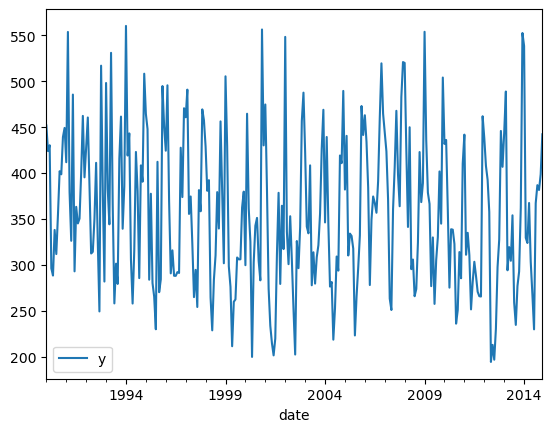

In [4]:
model = TimeSeriesAnalysis(df)
model.set_ts('Energy (kWh)')

print("Plot Time Series")
model.plot_ts();

Set Time Series Slice y Plot Acf Pacf


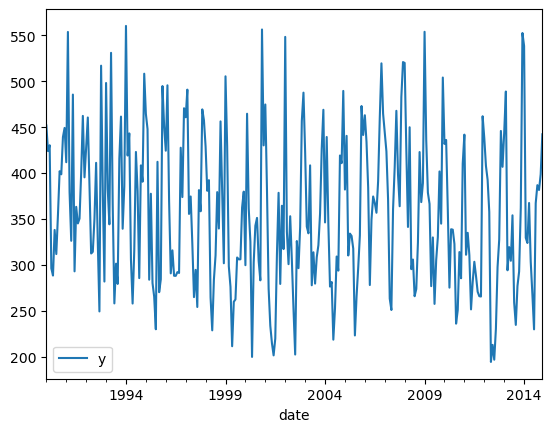

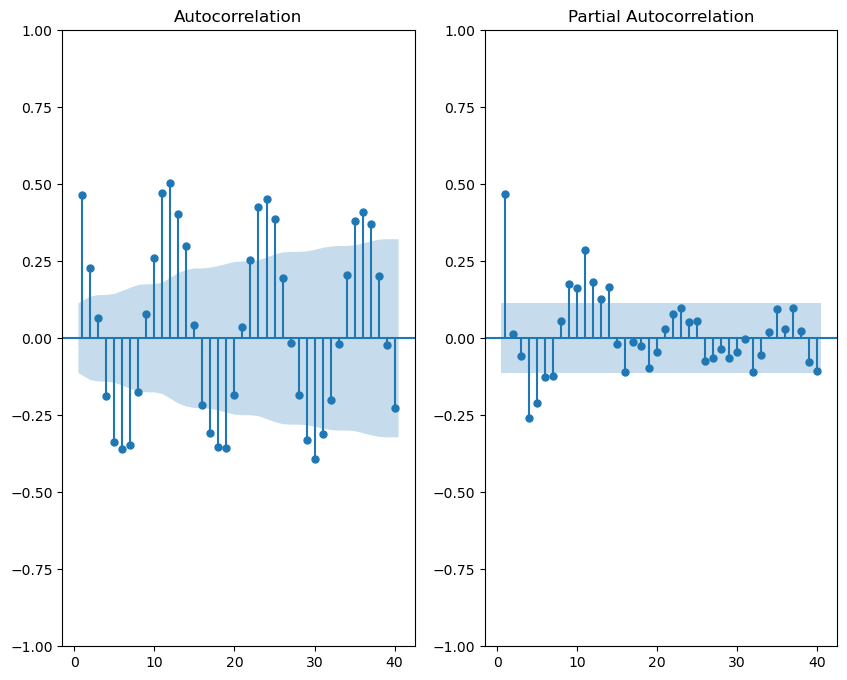

In [5]:
print("Set Time Series Slice y Plot Acf Pacf")
model.set_ts_slice()
model.plot_ts()

model.plot_acf_pacf(kwargs={'lags': 40})

Plot Acf Pacf 1


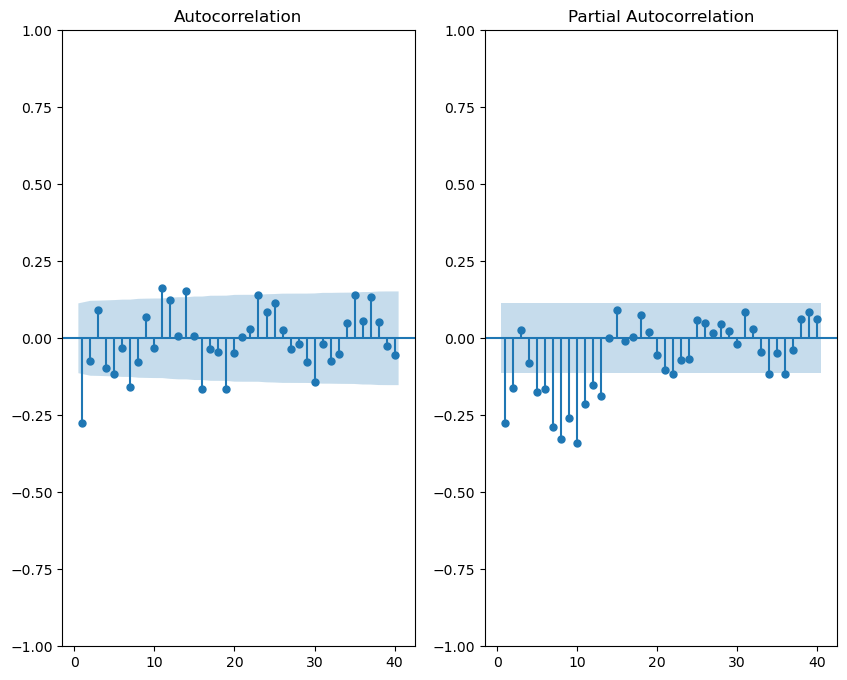

Seasonal Decompose


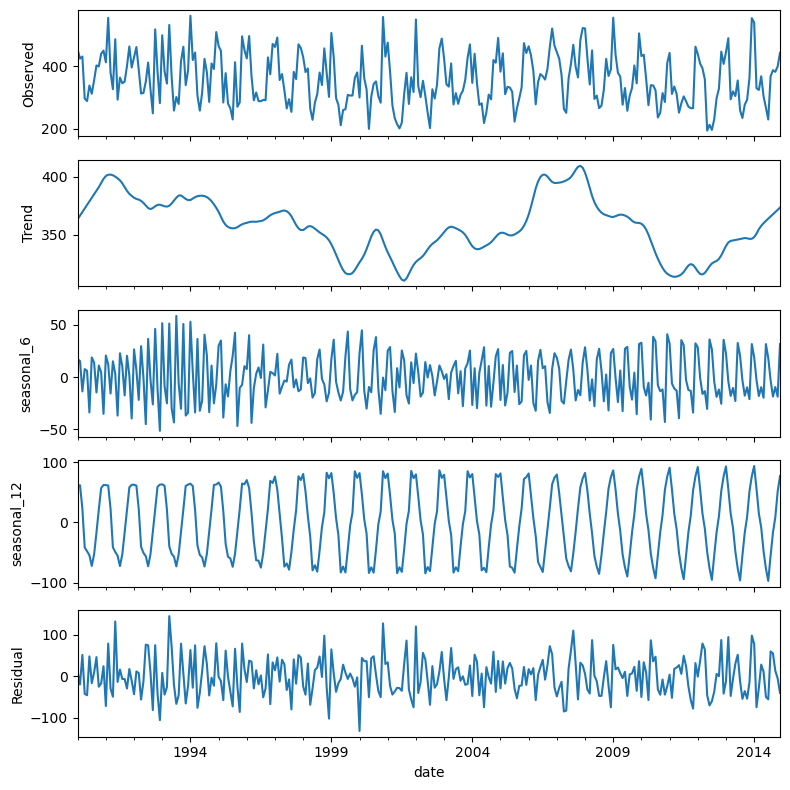

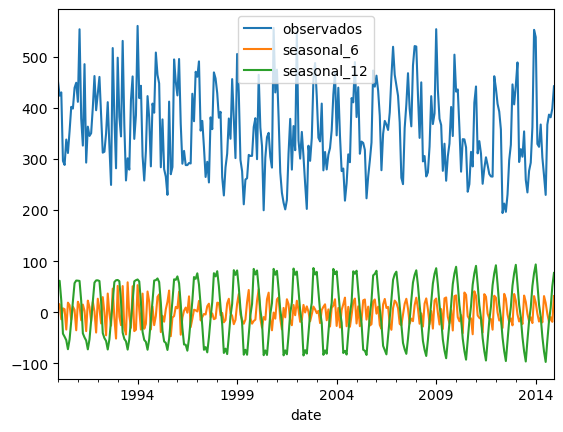

In [6]:
print("Plot Acf Pacf 1")
model.plot_acf_pacf(1, kwargs={'lags': 40})

print("Seasonal Decompose")
model.seasonal_decomp((6, 12))


seasonal_6
Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Sin diferenciar


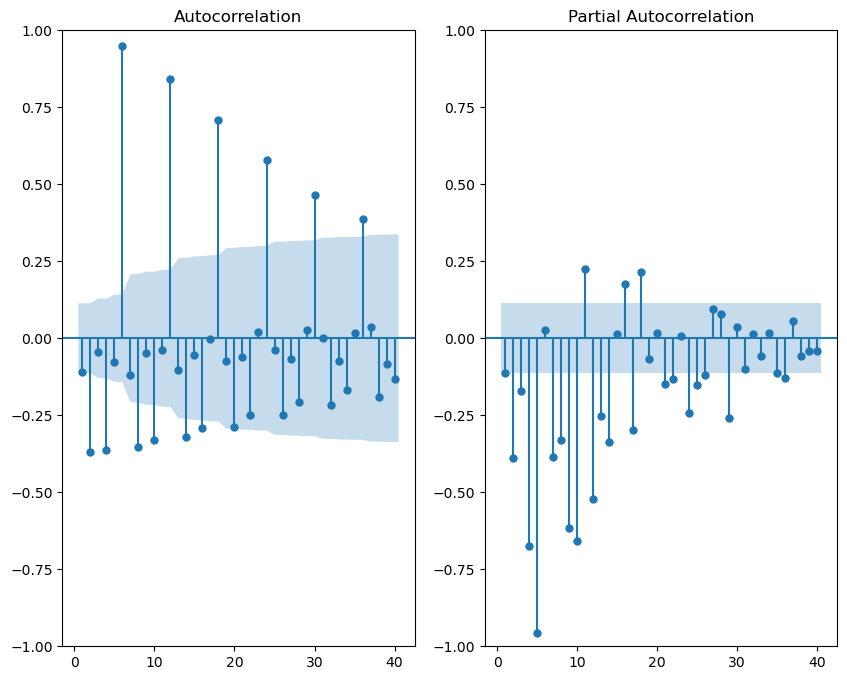

Diferenciada


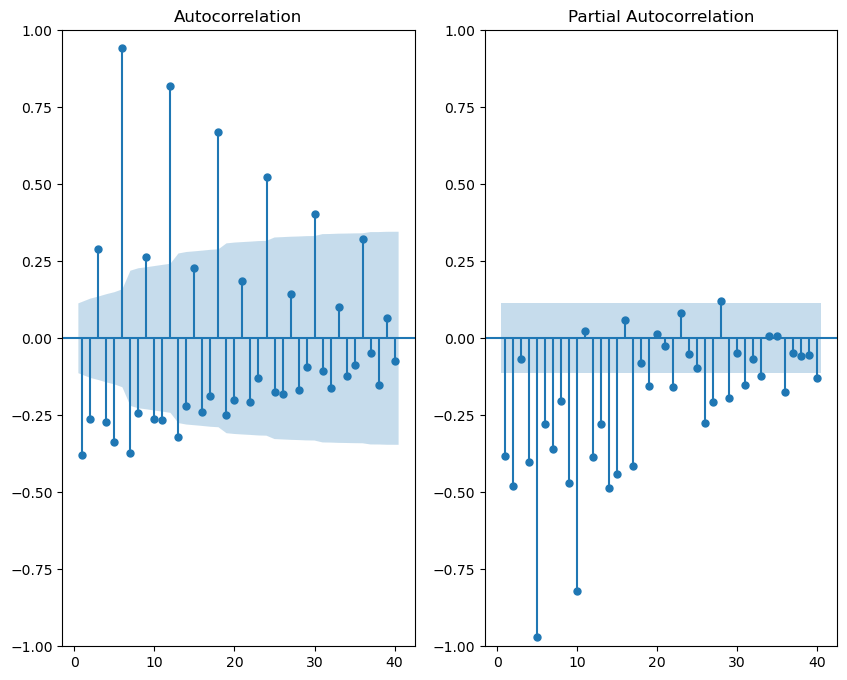



seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Sin diferenciar


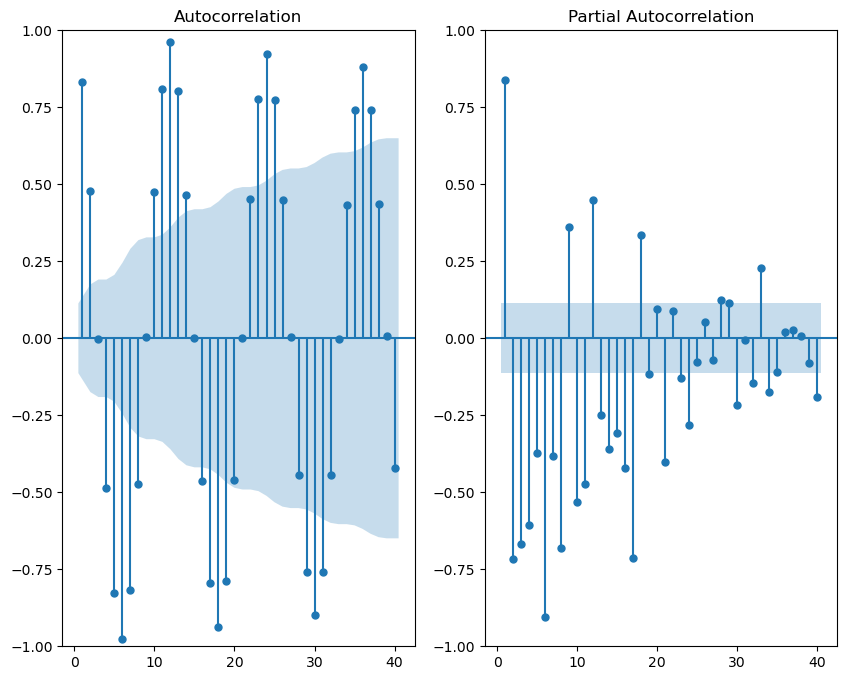

Diferenciada


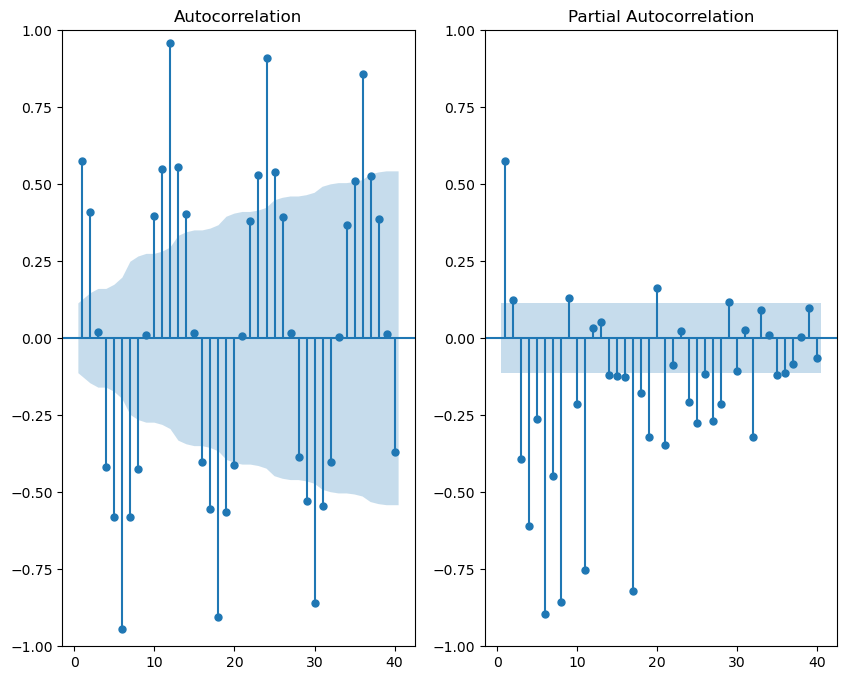

In [7]:
model.stationarity_analysis()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Sin diferenciar


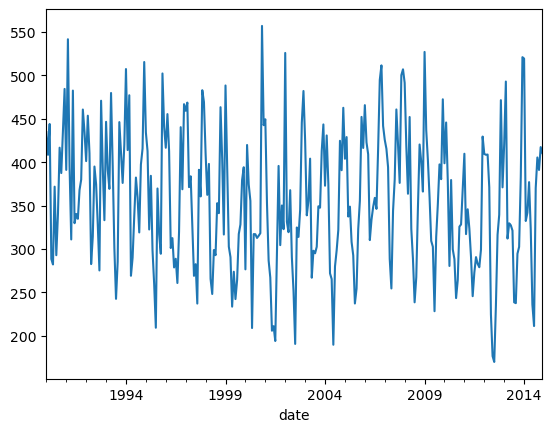

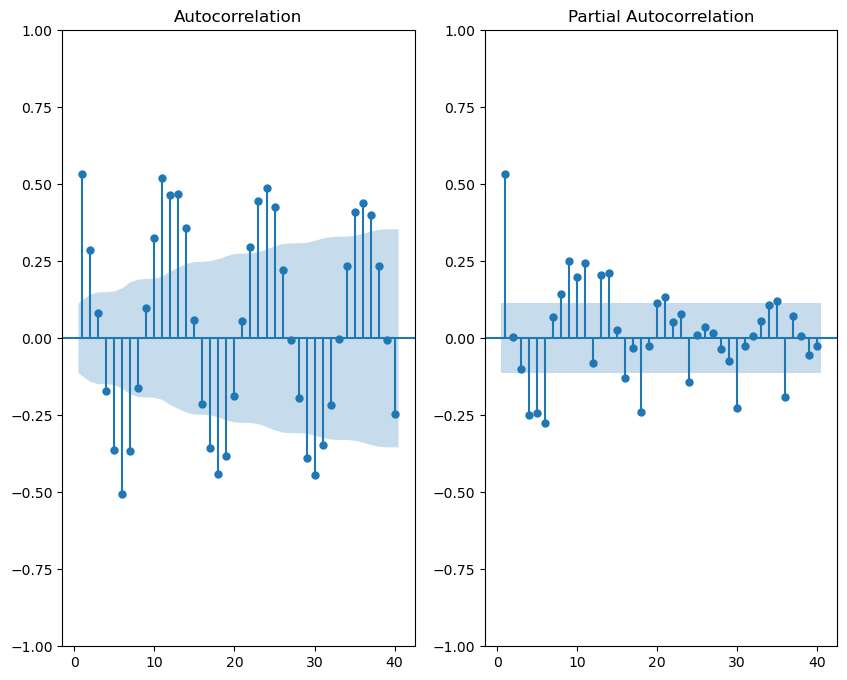

Diferenciada


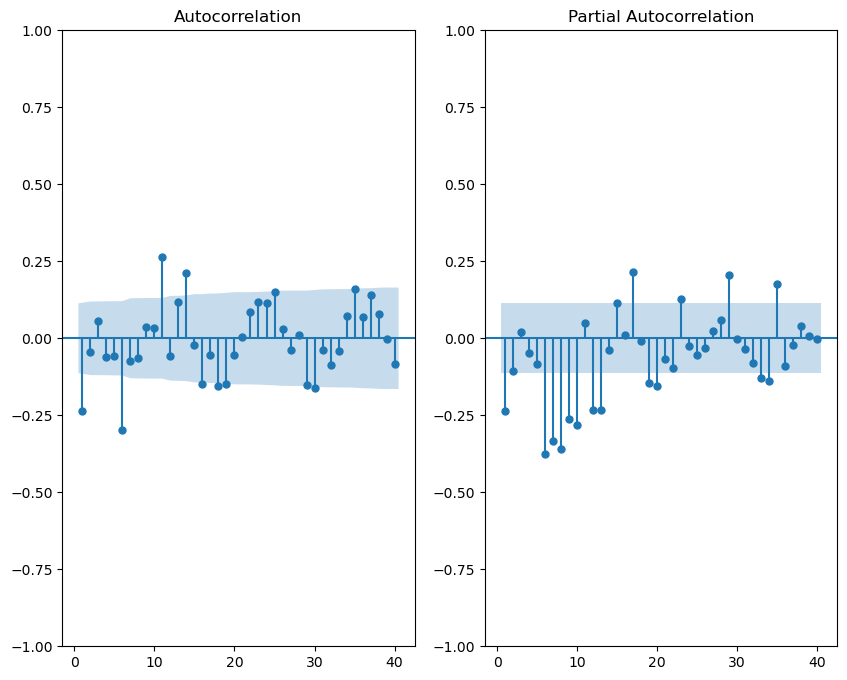

Diferenciada 2 veces


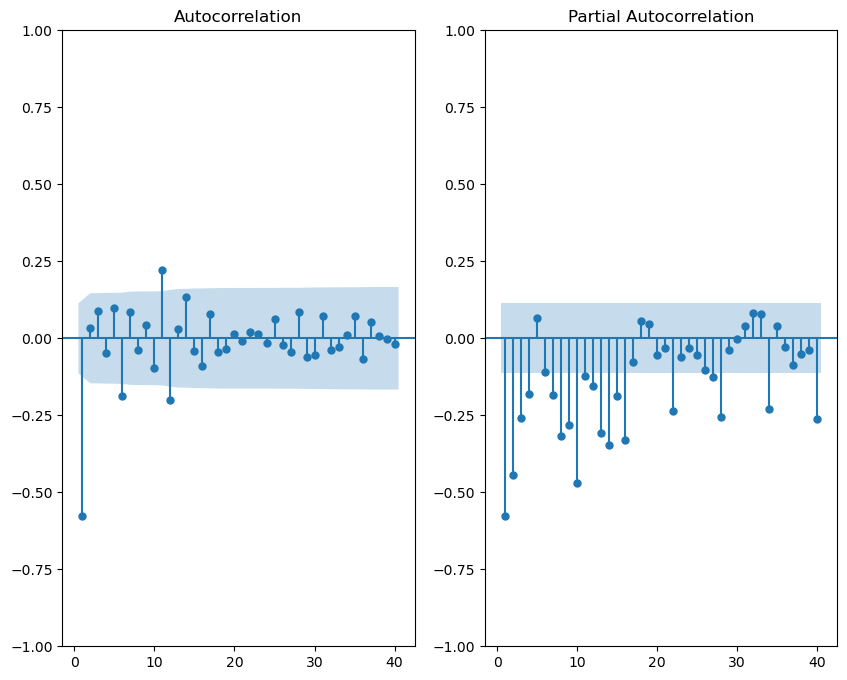

In [8]:
model.non_stationary_analysis(6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


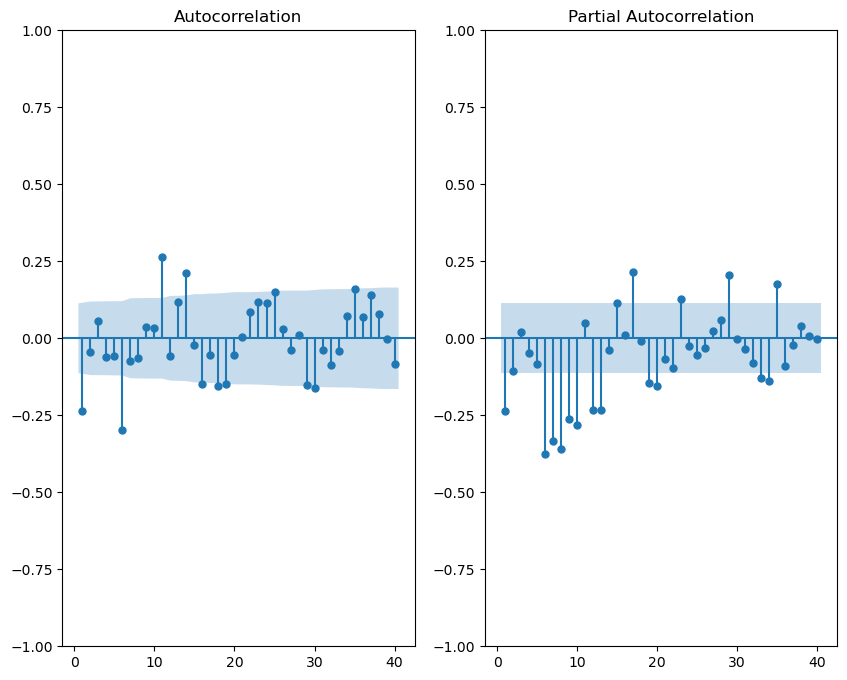

In [9]:
model.adf(False, model.non_seasonal.diff().dropna())
model.plot_acf_pacf(1, {'lags': 40}, False, model.non_seasonal)

In [10]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]

In [11]:
model.sarimax_params(p, d, q, P, D, Q)

posibleParams = model.find_params().sort_values(by=['AIC'], ascending=True);

In [12]:
posibleParams.head()

,params,AIC,BIC,LLF
174,"((2, 1, 0), (2, 0, 1, 6), 't')",225.786139,251.689244,-105.893069
196,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.099954,707.302616,-336.549977
208,"((2, 1, 1), (2, 0, 1, 6), 'n')",686.686002,712.589107,-336.343001
200,"((2, 1, 1), (1, 0, 2, 6), 'n')",686.723048,712.626153,-336.361524
197,"((2, 1, 1), (1, 0, 1, 6), 'c')",686.900039,712.803144,-336.45002


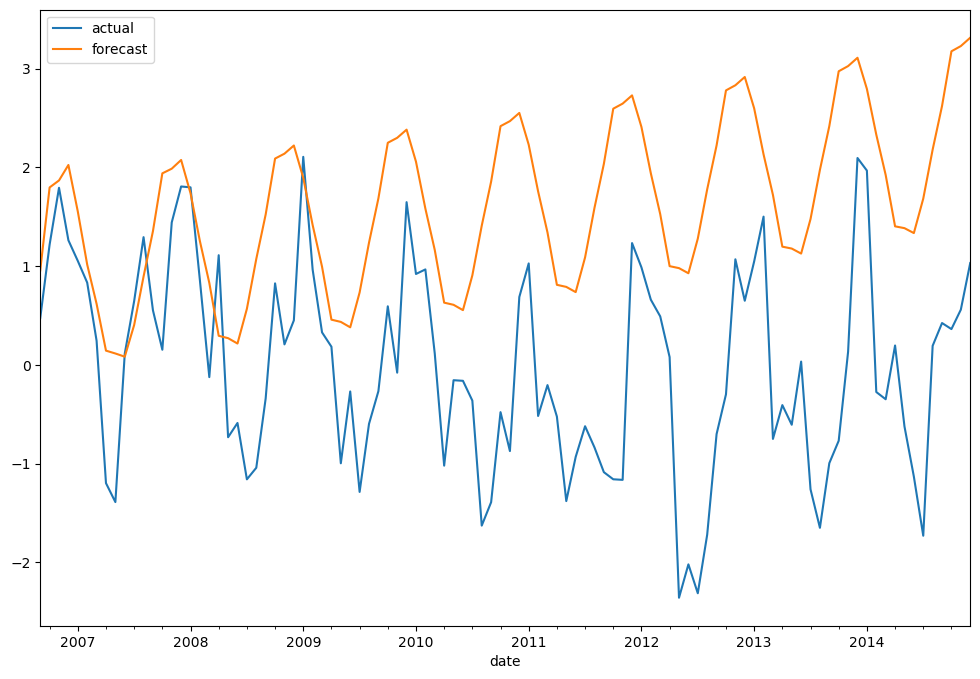

In [16]:
model.sarimax_model((2, 1, 0), (2, 0, 1, 6), 't')
model.predict(100)